<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/TrOCR/Fine_tune_TrOCR_on_IAM_Handwriting_Database_using_Seq2SeqTrainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prepare data

We first download the data. Here, I'm just using the IAM test set, as this was released by the TrOCR authors in the unilm repository. It can be downloaded from [this page](https://github.com/microsoft/unilm/tree/master/trocr). 

Let's make a [regular PyTorch dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html). We first create a Pandas dataframe with 2 columns. Each row consists of the file name of an image, and the corresponding text.

#### Generate Data

First lets generate some data. Using the package trdg at this repo [https://github.com/hezarai/trdg-persian](https://github.com/hezarai/trdg-persian) generate a 
tiny 1 million text images. The preferred command is below:


In [9]:
%%bash
repo_name="trdg-persian"
repo_url="https://github.com/hezarai/$repo_name.git"

# Check if the repo exists
if [ ! -d "$repo_name" ]; then
  # Clone the repo if it doesn't exist
  git clone "$repo_url"
else
  # Pull the latest changes if the repo exists
  cd "$repo_name"
  git pull
fi

Updating 3f6ced5..df75663
Fast-forward
 commands/fa-docs.txt            |  6 ++---
 setup.py                        |  2 +-
 trdg/data_generator.py          | 54 ++++++++++++++++++++++++++---------------
 trdg/generators/from_strings.py |  6 +++++
 trdg/run.py                     | 17 ++++++++++++-
 5 files changed, 60 insertions(+), 25 deletions(-)


In [2]:
# install libfreetype6-dev
# sudo apt-get -y install libfreetype6-dev
# sudo apt install libjpeg-dev zlib1g-dev
# close terminal and open notebook again!

In [10]:
!pip install -q transformers[torch] datasets jiwer accelerator
!pip uninstall -y pillow
!pip install pillow==9.5.0
!pip install -U trdg-persian/

Found existing installation: Pillow 9.5.0
Uninstalling Pillow-9.5.0:
  Successfully uninstalled Pillow-9.5.0
  Using cached Pillow-9.5.0-cp311-cp311-manylinux_2_28_x86_64.whl (3.4 MB)
Processing ./trdg-persian
  Preparing metadata (setup.py) ... done
  Created wheel for trdg: filename=trdg-1.7.0-py3-none-any.whl size=21628 sha256=3f8a6f749bbac4d17193a029dfb1b4195ed09c93b4d94a000c15307a67ac6725
  Stored in directory: /home/ai/.cache/pip/wheels/33/be/58/53e2d3157ff0578b3447abdf87abbc01fd70877ad65b834c4c
Successfully built trdg
  Attempting uninstall: trdg
    Found existing installation: trdg 1.7.0
    Uninstalling trdg-1.7.0:
      Successfully uninstalled trdg-1.7.0


In [33]:
!rm -rf outputs/

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
rm: cannot remove 'outputs/dark': Directory not empty


In [34]:
!trdg --output_dir ./outputs/bw -l fa -fd trdg-persian/trdg/fonts/fa --dict trdg-persian/trdg/dicts/lscp-raw-1m-clean.txt -t 48 -c 300000 -w 1 -rqf 0.5 -rqp 0.2 -m 3,3,3,3 -tc "#284854,#542828" -k 5 -rk -na 1 -ws -b 0 -f 48 -tdir rtl
!trdg --output_dir ./outputs/lights -l fa -fd trdg-persian/trdg/fonts/fa --dict trdg-persian/trdg/dicts/lscp-raw-1m-clean.txt -t 48 -c 300000 -w 1 -m 3,3,3,3 -tc "#284854,#542828" -k 5 -rk -na 1 -ws -b 0 -f 48 -tdir rtl -b 3 -id trdg-persian/trdg/generators/documents_light
!trdg --output_dir ./outputs/dark -l fa -fd trdg-persian/trdg/fonts/fa --dict trdg-persian/trdg/dicts/lscp-raw-1m-clean.txt -t 48 -c 300000 -w 1 -rqf 0.5 -rqp 0.2 -m 3,3,3,3 -tc "#ed8c8c,#8ceced" -k 5 -rk -na 1 -ws -b 0 -f 48 -tdir rtl -b 3 -id trdg-persian/trdg/generators/documents_dark

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Missing modules for handwritten text generation.
100%|██████████████████████████████████| 300000/300000 [11:00<00:00, 453.92it/s]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Missing modules for handwritten text generation.
100%|██████████████████████████████████| 300000/300000 [06:22<00:00, 785.17it/s]
huggingface/tokenizers: The current process just got forked, after parallelism has already b

Then you have to move the outputs folder (`./outputs/bw`) to `data/bw` in this folder.

Now lets do the actual job.

### Read Dataset

In [35]:
import os

import pandas as pd

In [36]:
data_path = "outputs/bw"  # PROVIDE THE RIGHT PATH TO IMAGE DATA FOLDER
encoder_path = "google/vit-base-patch16-224-in21k"
decoder_path = "HooshvareLab/roberta-fa-zwnj-base"
test_data_path = "outputs/bw-test/"

#### Generate image/text pairs dataframe

In [37]:
def get_paths_labels(data_path_:str):
    paths = []
    labels = []
    for f in os.listdir(data_path_):
        label = f.split("_")[1].split(".")[0]
        paths.append(f)
        labels.append(label)
    return paths, labels

In [38]:
paths, labels = get_paths_labels(data_path)

In [39]:
df = pd.DataFrame({"file_name": paths, "text": labels})

In [40]:
df.head()

,file_name,text
0,111868_کی تموم میشه کی دیگه خسته نیستیم.jpg,کی تموم میشه کی دیگه خسته نیستیم
1,36408_خوب شد گفتی برم جورابامو بپوشم.jpg,خوب شد گفتی برم جورابامو بپوشم
2,120423_خوشتر از هر دو جهان آنجا بودکه مرا با ت...,خوشتر از هر دو جهان آنجا بودکه مرا با تو سر و ...
3,220013_واقعا وقاحت و حماقت عرزشیها پایان نداره...,واقعا وقاحت و حماقت عرزشیها پایان نداره
4,275471_خیلی باز شده. خیلی..jpg,خیلی باز شده


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   file_name  300000 non-null  object
 1   text       300000 non-null  object
dtypes: object(2)
memory usage: 4.6+ MB


We split up the data into training + testing, using sklearn's `train_test_split` function.

#### Train/Test split

In [42]:
from sklearn.model_selection import train_test_split

train_df, eval_df = train_test_split(df, test_size=0.2)
# we reset the indices to start from zero
train_df.reset_index(drop=True, inplace=True)
eval_df.reset_index(drop=True, inplace=True)

Each element of the dataset should return 2 things:
* `pixel_values`, which serve as input to the model.
* `labels`, which are the `input_ids` of the corresponding text in the image.

We use `TrOCRProcessor` to prepare the data for the model. `TrOCRProcessor` is actually just a wrapper around a `ViTFeatureExtractor` (which can be used to resize + normalize images) and a `RobertaTokenizer` (which can be used to encode and decode text into/from `input_ids`). 

### Dataset Class

In [43]:
import torch
from torch.utils.data import Dataset
from PIL import Image


class LSCPSynthDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128, h_flip=True, return_text=False):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length
        self.h_flip = h_flip
        self.return_text = return_text

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text
        file_name = self.df["file_name"][idx]
        text = self.df["text"][idx]
        # prepare image (i.e. resize + normalize)
        image_path = os.path.join(self.root_dir, file_name)
        image = Image.open(image_path).convert("RGB")
        if self.h_flip:
            image.transpose(Image.FLIP_LEFT_RIGHT)
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(
            text, padding="max_length", max_length=self.max_target_length, 
        ).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100
            for label in labels]
        labels = torch.tensor(labels)
        
        encoding = {
            "pixel_values": pixel_values.squeeze(),
            "labels": labels,
        }
        if self.return_text:
            encoding["text"] = text
        return encoding

Let's initialize the training and evaluation datasets:

In [44]:
from transformers import TrOCRProcessor, AutoTokenizer

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-stage1", size=224)
tokenizer = AutoTokenizer.from_pretrained(decoder_path)
processor.tokenizer = tokenizer
train_dataset = LSCPSynthDataset(root_dir=data_path, df=train_df, processor=processor)
eval_dataset = LSCPSynthDataset(root_dir=data_path, df=eval_df, processor=processor)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [45]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 240000
Number of validation examples: 60000


Let's verify an example from the training dataset:

In [46]:
image, labels = list(train_dataset[0].values())
print(image.shape, labels.shape)

torch.Size([3, 224, 224]) torch.Size([128])


We can also check the original image and decode the labels:

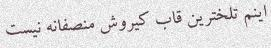

In [47]:
image = Image.open(os.path.join(train_dataset.root_dir, train_df['file_name'][0])).convert("RGB")
image

In [48]:
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

اینم تلخترین قاب کیروش منصفانه نیست


## Collator

In [49]:
def data_collator(features):
    tokenizer.model_input_names = ["labels"]
    features = tokenizer.pad(
            features,
            padding="longest",
            return_tensors="pt",
        )
    return features

## Train a model

Here, we initialize the TrOCR model from its pretrained weights. Note that the weights of the language modeling head are already initialized from pre-training, as the model was already trained to generate text during its pre-training stage. Refer to the paper for details.

In [50]:
from transformers import VisionEncoderDecoderModel

model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(encoder_path, decoder_path)

Some weights of RobertaForCausalLM were not initialized from the model checkpoint at HooshvareLab/roberta-fa-zwnj-base and are newly initialized: ['roberta.encoder.layer.1.crossattention.self.value.weight', 'roberta.encoder.layer.3.crossattention.output.dense.weight', 'roberta.encoder.layer.2.crossattention.output.dense.weight', 'roberta.encoder.layer.6.crossattention.self.value.weight', 'roberta.encoder.layer.8.crossattention.output.LayerNorm.bias', 'roberta.encoder.layer.3.crossattention.self.query.weight', 'roberta.encoder.layer.9.crossattention.output.dense.weight', 'roberta.encoder.layer.8.crossattention.self.query.bias', 'roberta.encoder.layer.0.crossattention.self.value.bias', 'roberta.encoder.layer.9.crossattention.self.value.weight', 'roberta.encoder.layer.6.crossattention.self.value.bias', 'roberta.encoder.layer.0.crossattention.self.key.weight', 'roberta.encoder.layer.7.crossattention.self.value.weight', 'roberta.encoder.layer.1.crossattention.self.key.bias', 'roberta.encode

Importantly, we need to set a couple of attributes, namely:
* the attributes required for creating the `decoder_input_ids` from the `labels` (the model will automatically create the `decoder_input_ids` by shifting the `labels` one position to the right and prepending the `decoder_start_token_id`, as well as replacing ids which are -100 by the pad_token_id)
* the vocabulary size of the model (for the language modeling head on top of the decoder)
* beam-search related parameters which are used when generating text.

In [51]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

Next, we can define some training hyperparameters by instantiating the `training_args`. Note that there are many more parameters, all of which can be found in the [documentation](https://huggingface.co/transformers/main_classes/trainer.html#seq2seqtrainingarguments). You can for example decide what the batch size is for training/evaluation, whether to use mixed precision training (lower memory), the frequency at which you want to save the model, etc.

In [52]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=5,
    fp16=True,
    report_to=None,
    output_dir="./",
    logging_steps=100,
    save_steps=5000,
    eval_steps=5000,
)

We will evaluate the model on the Character Error Rate (CER), which is available in HuggingFace Datasets (see [here](https://huggingface.co/metrics/cer)).

In [53]:
from datasets import load_metric

cer_metric = load_metric("cer")

The compute_metrics function takes an `EvalPrediction` (which is a NamedTuple) as input, and should return a dictionary. The model will return an EvalPrediction at evaluation, which consists of 2 things:
* predictions: the predictions by the model.
* label_ids: the actual ground-truth labels.

In [54]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    preds = []
    labels = []
    for pred, label in zip(pred_str, label_str):
        if len(pred.strip()) and len(label.strip()):
            preds.append(pred)
            labels.append(label)
    cer = cer_metric.compute(predictions=preds, references=labels)
    return {"cer": cer}

Let's train! We also provide the `default_data_collator` to the Trainer, which is used to batch together examples.

Note that evaluation takes quite a long time, as we're using beam search for decoding, which requires several forward passes for a given example.

In [55]:
from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
)
trainer.train()

/home/ai/anaconda3/envs/torch_gpu/lib/python3.11/site-packages/transformers/models/trocr/processing_trocr.py:135: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Cer
5000,3.449200,3.635506,0.570429
10000,1.883200,2.463363,0.339685
15000,1.305000,1.852611,0.230214
20000,0.904700,1.646362,0.170812
25000,0.639900,1.543144,0.147478
30000,0.551800,1.591088,0.130814
35000,0.444400,1.483928,0.116458


/home/ai/anaconda3/envs/torch_gpu/lib/python3.11/site-packages/transformers/generation/utils.py:1417: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(


TrainOutput(global_step=37500, training_loss=1.6015383753458659, metrics={'train_runtime': 38705.9191, 'train_samples_per_second': 31.003, 'train_steps_per_second': 0.969, 'total_flos': 2.172439382851584e+20, 'train_loss': 1.6015383753458659, 'epoch': 5.0})

In [56]:
trainer.evaluate(eval_dataset)

{'eval_loss': 1.4037017822265625,
 'eval_cer': 0.11530467728891257,
 'eval_runtime': 1992.9448,
 'eval_samples_per_second': 30.106,
 'eval_steps_per_second': 0.471,
 'epoch': 5.0}

In [65]:
trainer.save_model("./checkpoint-37500/")
torch.save(trainer.optimizer.state_dict(), "./checkpoint-37500/optimizer.pt")
torch.save(trainer.lr_scheduler.state_dict(), "./checkpoint-37500/scheduler.pt")
processor.save_pretrained("./checkpoint-37500/")

In [68]:
trainer._save_checkpoint(trainer.model, trainer._trial)
processor.save_pretrained("./checkpoint-37500/")

# Save on HF

In [70]:
!pip install -U hezar

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  Obtaining dependency information for hezar from https://files.pythonhosted.org/packages/e5/71/2e4156c9d741d939e4fe4d4ee228ff90d7023bf9039ceb69b81a08a4bd06/hezar-0.26.10-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 788.9 kB/s eta 0:00:00a 0:00:01
  Attempting uninstall: hezar
    Found existing installation: hezar 0.24.4
    Uninstalling hezar-0.24.4:
      Successfully uninstalled hezar-0.24.4


In [79]:
from hezar import list_available_models

list_available_models()

['bert_lm',
 'bert_sequence_labeling',
 'bert_text_classification',
 'crnn_image2text',
 'distilbert_lm',
 'distilbert_sequence_labeling',
 'distilbert_text_classification',
 'roberta_lm',
 'roberta_sequence_labeling',
 'roberta_text_classification',
 't5_text_generation',
 'whisper_speech_recognition']

In [76]:
conf = hezar.ModelConfig.load("trocr-base-fa-v2")
hezar_trocr = TrOCRImage2Text(conf)
hezar_trocr.trocr = model
hezar_trocr.save("trocr-base-fa-v2")  # check if everything is saved properly
hezar_trocr.push_to_hub("hezarai/trocr-base-fa-v2")

KeyError: 'trocr_image2text'

# Test

In [82]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel, AutoTokenizer

processor = TrOCRProcessor.from_pretrained("./checkpoint-32000/", size=224)
model = VisionEncoderDecoderModel.from_pretrained('./checkpoint-32000/')

In [83]:
test_paths, test_labels = get_paths_labels(test_data_path)
test_df = pd.DataFrame({"file_name": test_paths, "text": test_labels})
test_dataset = LSCPSynthDataset(root_dir=test_data_path, df=test_df, processor=processor, return_text=True)
for encoding in test_dataset:
    generated_ids = model.generate(encoding['pixel_values'].unsqueeze(0))
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    print("label:", encoding['text'], "\n", "pred:", generated_text)

label:  چه شبیه خودته 
 pred:  چه شبیه خودته
label:  دایرکت کردم 
 pred:  دایرکت کردم
label:  نه بیا تجدید خاطره هم میشه 
 pred:  نه بیا تجدید خاطره هم میشه
label:  مرسی، روز خوبی داشته باشین 
 pred:  مرسی، روز خوبی داشته باشین
label:  نظر سنجی بذار با هفت هشت تا گزینه 
 pred:  نظر سنجی بذار با هفت هشت تا گزینه
label:  چرا 
 pred:  چرا
label: بگو با هشتگ توییت کنن 
 pred: بگو با هشتگ توییت کنن
label:  خبرنگار ترکش خمپاره پیشونیش رو چاک داده بود 
 pred:  خبرنگار ترکش خمپاره پیشونیش رو چاک داده بود
label:  لامصب بردیم سال پیش 
 pred:  لامصب بردیم سال پیش
label: خوب این آخر هفته دوستامو چجوری بپیچونم لش کنم تو خونه فیلم ببینم 
 pred: خوب این در خطمه دوستانمون چجوری بیچارهام مثل کمتر تو خونه فیلم ببینم
label:  دهنش که بسته است چجوری اعتراف کنه  
 pred: جدیش که بسته است چجوری اعتراف کنه 
label: امریکا هم داره البته گمونم جز دار دسته دموکراتها باشه  
 pred: امروز که هم داره شب گمونم جر از دست میده موزیک ابلهشه 
label:  اپوزیسیون فقط عبدالرضایی و مریم رجوی 
 pred:  اپوزسیونها فقط عنقلاب اسلام

UnidentifiedImageError: cannot identify image file 'outputs/bw-test/2385_ مبارکه .jpg'

In [85]:
from huggingface_hub import login
login()

In [86]:
model.push_to_hub("hezarai/trocr-tiny-fa")
processor.push_to_hub("hezarai/trocr-tiny-fa")

pytorch_model.bin:   0%|          | 0.00/933M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/hezarai/trocr-tiny-fa/commit/28e8a3413d59faab9d60f78e382df316c768c682', commit_message='Upload processor', commit_description='', oid='28e8a3413d59faab9d60f78e382df316c768c682', pr_url=None, pr_revision=None, pr_num=None)

*_:)_*